In [1]:
import tensorflow as tf
import numpy as np
import gpflow
gpflow.config.set_default_float(np.float32)

from sgptools.utils.metrics import *
from sgptools.utils.misc import *
from sgptools.models.continuous_sgp import *
from sgptools.kernels.neural_kernel import init_neural
from sgptools.utils.gpflow import get_model_params

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.random.seed(10)
tf.random.set_seed(10)

2024-03-30 14:40:16.718007: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-30 14:40:16.719757: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-30 14:40:16.753132: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-30 14:40:16.753994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-30 14:40:17.396101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Generate non-stationary data

(200, 2) (200, 1)
(5000, 2) (5000, 1)


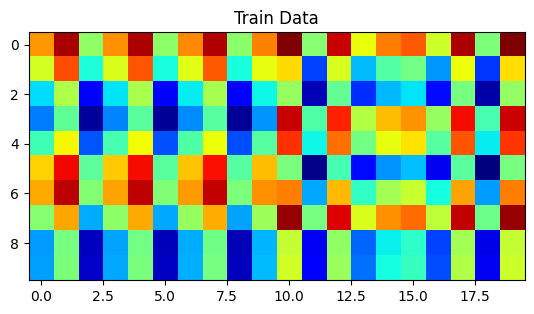

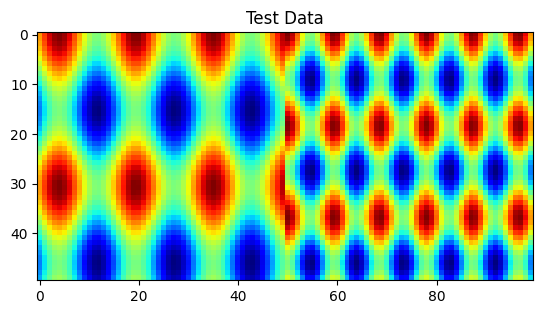

In [13]:
def non_stationary_function(X, Y):
    Z1 = np.sin(X/10) + np.cos(Y/10)
    Z2 = np.cos(X/6) + np.cos(Y/6)
    Z = np.concatenate([Z1[:, ::2], Z2[:, ::2]], 
                       axis=1)
    return Z

# Generate data
train_data_dims = (20, 10)
x = np.linspace(0, 200, train_data_dims[0])
y = np.linspace(0, 100, train_data_dims[1])
X, Y = np.meshgrid(x, y)
Z = non_stationary_function(X, Y)

X_train = np.stack([X.ravel(), Y.ravel()], 
                   axis=1).astype(np.float32)
Y_train = Z.ravel()[:, None].astype(np.float32)
print(X_train.shape, Y_train.shape)

test_data_dims = (100, 50)
x = np.linspace(0, 200, test_data_dims[0])
y = np.linspace(0, 100, test_data_dims[1])
X, Y = np.meshgrid(x, y)
Z = non_stationary_function(X, Y)

X_test = np.stack([X.ravel(), Y.ravel()], 
                  axis=1).astype(np.float32)
Y_test = Z.ravel()[:, None].astype(np.float32)
print(X_test.shape, Y_test.shape)

# Normalize the data
Xscalar = StandardScaler()
X_train = Xscalar.fit_transform(X_train)
X_test = Xscalar.transform(X_test)

yScalar = StandardScaler()
Y_train = yScalar.fit_transform(Y_train)
Y_test = yScalar.transform(Y_test)

# Plot the data
plt.figure()
plt.imshow(Y_train.reshape(train_data_dims[1], 
                           train_data_dims[0]), 
           cmap='jet')
plt.gca().set_aspect('equal')
plt.title('Train Data')
plt.show()

plt.figure()
plt.imshow(Y_test.reshape(test_data_dims[1], 
                          test_data_dims[0]), 
           cmap='jet')
plt.gca().set_aspect('equal')
plt.title('Test Data')
plt.show()

## Learn kernel parameters from coarsely sampled data 

In [ ]:
# Model / inference hyperparameters
num_inducing = 100
lr = 1e-2
max_steps = 5000
Q = 3

# Initialize non-stationary kernel model
print('Initializing model...')
Z = get_inducing_pts(X_train, num_inducing)*0.6
model = init_neural(X_train, Y_train, n_inits=5,
                    inducing_variable=Z,
                    Q=Q,
                    hidden_sizes=(4, 4))

# Create optimizer
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
                      lr, 
                      decay_steps=50, 
                      decay_rate=0.98)
loss = optimize_model(model, 
                      max_steps=max_steps,
                      lr=learning_rate,
                      optimizer='tf')

# Plot loss
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

kernels = []
noice_vars = []
labels = ['non_stationary_demo_', 'stationary_demo_']

kernels.append(model.kernel)
noice_vars.append(model.likelihood.variance.numpy())

# Get stationary kernel
_, noise_variance, kernel = get_model_params(X_train, Y_train, 
                                             lengthscales=[1.0, 0.5])
kernels.append(kernel)
noice_vars.append(noise_variance)

## Get Continuous-SGP solution with the learned neural kernel function

In [ ]:
for i, (kernel, noice_var) in enumerate(zip(kernels, noice_vars)):
        for num_placements in [4, 9, 16]:
                Xu_init = get_inducing_pts(X_train, num_placements)*0.6
                Xu_init.astype(np.float32)
                sgpr, _ = continuous_sgp(num_placements, 
                                                X_train,
                                                noise_variance=noice_var,
                                                kernel=kernel,
                                                Xu_init=Xu_init)
                sgp_sol_sp = sgpr.inducing_variable.Z.numpy()
                Xu_X, Xu_y = cont2disc(sgp_sol_sp, candidates=X_test,
                                candidate_labels=Y_test)

                # Get the GP predictions
                gpr = gpflow.models.GPR((Xu_X, Xu_y),
                                        noise_variance=noice_var,
                                        kernel=kernel)
                y_pred, y_var = gpr.predict_f(X_test)
                y_pred = y_pred.numpy()

                rmse = np.sqrt(np.mean((y_pred - Y_test)**2))

                plt.figure()
                plt.imshow(y_pred.reshape(test_data_dims[1], test_data_dims[0]),
                        cmap='jet', origin='lower',
                        extent=[np.min(X_test[:, 0]), np.max(X_test[:, 0]),
                                np.min(X_test[:, 1]), np.max(X_test[:, 1])])
                plt.gca().set_aspect('equal')
                plt.scatter(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], c='k', marker='p', s=100)
                plt.title('Number of Sensors: {}    RMSE: {:.3f}'.format(num_placements, rmse))
                plt.xlabel('X')
                plt.ylabel('Y')
                plt.savefig(labels[i]+f'{num_placements}.pdf', dpi=300, bbox_inches='tight')
                plt.show()

In [ ]:
plt.figure()
plt.imshow(Y_test.reshape(test_data_dims[1], test_data_dims[0]),
           cmap='jet', origin='lower',
           extent=[np.min(X_test[:, 0]), np.max(X_test[:, 0]),
                   np.min(X_test[:, 1]), np.max(X_test[:, 1])])
plt.gca().set_aspect('equal')
plt.title('Ground Truth')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('non_stationary_demo_gt.pdf', dpi=300, bbox_inches='tight')
plt.show()